In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Given the background in the Google doc, lets begin by loading and exploring the data. 

1) What features are available and what do a few data points look like?

2) Are there any NULL values?

3) What are the basic statistics of the features?

**There is a nice summary of this analysis with takeaways at the end of this notebook**

In [13]:
df = pd.read_csv('./input/conversion_data.csv')

print(df.head(5),'\n\n')
print('---------------------------')
print("Number of null values: ")
print(df.isnull().sum())
print('---------------------------\n\n')
df.describe()


  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0 


---------------------------
Number of null values: 
country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64
---------------------------




,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


There are five features (age, country, source, new_user, and total_pages_visited) and one target (converted). Age and total_pages_visited are numerical features, new_user is a binary categorical feature, and country and source are multi-class categorical.

Lets explore these features in more detail to see if there are any interesting patterns / correlations between the features and target:

In [51]:
# but first, lets check and see what fraction
# of the users convert to get an idea of how balanced this 
# target is / is not:
df['converted'].value_counts() / df['converted'].count()

0    0.967742
1    0.032258
Name: converted, dtype: float64

In [167]:
# and while we're at it, lets check and see fraction of new users
print(df['new_user'].value_counts() / df['new_user'].count())
df.groupby(['new_user','converted']).size() / df.groupby(['new_user']).size()

1    0.685465
0    0.314535
Name: new_user, dtype: float64


new_user  converted
0         0            0.927998
          1            0.072002
1         0            0.985979
          1            0.014021
dtype: float64

Clearly a majority of the traffic DOES NOT yield a conversion, with only 3.23% of the users converting. 

It is interesting to note that a majority of the sample are new users. More on this later, but this may suggest there could be more done to increase return traffic (under the assumption that this isn't just driven by a particularly strong / exponential growth in new user traffic). This is especially true given that a higher fraction of returning users are converted than new users.

## Age

There is clearly a wide range of users ages (up to 123! but it is probable safe to assume that the oldest human alive did not visit the website and that this particular value is not real).

In [42]:
df['age'].quantile(0.99)

52.0

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


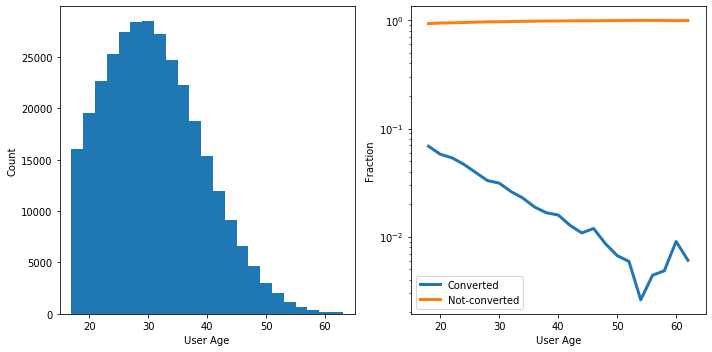

In [48]:
#
# Looking at age, but cutting off distribution around 99% 
# (rather than all the way up to 100).
#
bins = np.arange(15, 65, 2)
converted, bins = np.histogram(df['age'], weights=df['converted'],
                          bins = bins)
not_converted, bins = np.histogram(df['age'],
                                   weights=np.abs(df['converted']-1),
                                   bins = bins)
cent = 0.5*(bins[1:]+bins[:-1])
total = converted+not_converted

fig,ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

ax[0].hist(df['age'],bins=bins)
ax[0].set_ylabel('Count')

f_c = converted/total
f_c[total==0] = np.nan
f_nc = not_converted/total
f_nc[total==0] = np.nan

ax[1].plot(cent, f_c, lw = 3, color = 'C0', label = 'Converted')
ax[1].plot(cent, f_nc, lw=3,color = 'C1', label = 'Not-converted')
ax[1].semilogy()
ax[1].set_ylabel("Fraction")
ax[1].legend(loc='best')

for a in ax:
    a.set_xlabel('User Age')
    a.set_xlim(15,65)

plt.tight_layout()

Here we see that the age distribution looks somewhat gaussian. A majority of the users are in their 20's and early-mid 30's. Given that a majority of users do not convert, it is not surprising that the conversion fraction in each age interval (right panel) is large, but there is a very clear trend of fraction of converted users with age. There is a deacreasing power-law of conversion fraction with increasing age, up until an age of about 52, where there is a (roughly) power-law increase again (there does seem to be sufficient users (>1000) that this is a real feature and not a small number statistics issue).

In [56]:
df['age'][df['age']>55].count() 

1156

The question to be asked is: why are the younger users converting at a higher rate? 

First, lets sanity check and check the number of 

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


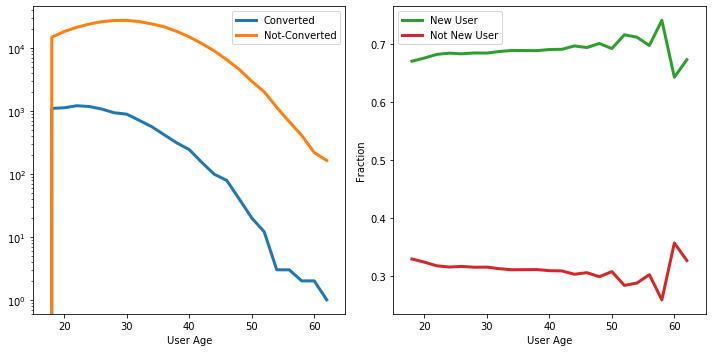

In [64]:
bins = np.arange(15, 65, 2)
nu, bins = np.histogram(df['age'], weights=df['new_user'],
                          bins = bins)
not_nu, bins = np.histogram(df['age'],
                                   weights=np.abs(df['new_user']-1),
                                   bins = bins)
cent = 0.5*(bins[1:]+bins[:-1])
total = nu+not_nu

fig,ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

ax[0].plot(cent, converted, lw = 3, color = 'C0', label = "Converted")
ax[0].plot(cent, not_converted, lw = 3, color = 'C1', label = "Not-Converted")
ax[0].legend(loc='best')
ax[0].semilogy()

f_nu = nu/total
f_nu[total==0] = np.nan
f_notnu = not_nu/total
f_notnu[total==0] = np.nan

ax[1].plot(cent, f_nu, lw = 3, color = 'C2', label = 'New User')
ax[1].plot(cent, f_notnu, lw=3,color = 'C3', label = 'Not New User')
#ax[1].semilogy()
ax[1].set_ylabel("Fraction")
ax[1].legend(loc='best')

for a in ax:
    a.set_xlabel('User Age')
    a.set_xlim(15,65)

plt.tight_layout()

The left panel here is somewhat redundant with before, but this illustrates that there is indeed a decreasing trend of conversion with increasing age, but this does point out another feature that the initial descrease in conversion fraction with age over 20-30 year olds is due mostly to an increase in the non-conversion fraction from before while the total number of converted users remains roughly fixed over this range.

There does not appear to be a significant correlation with new / not new users and user age, as the fractional distributions for each are roughly flat with age. However, there is a very slight increase in new usership for older users, with a noticeable uptick around the age of 50+.

## Pages Viewed

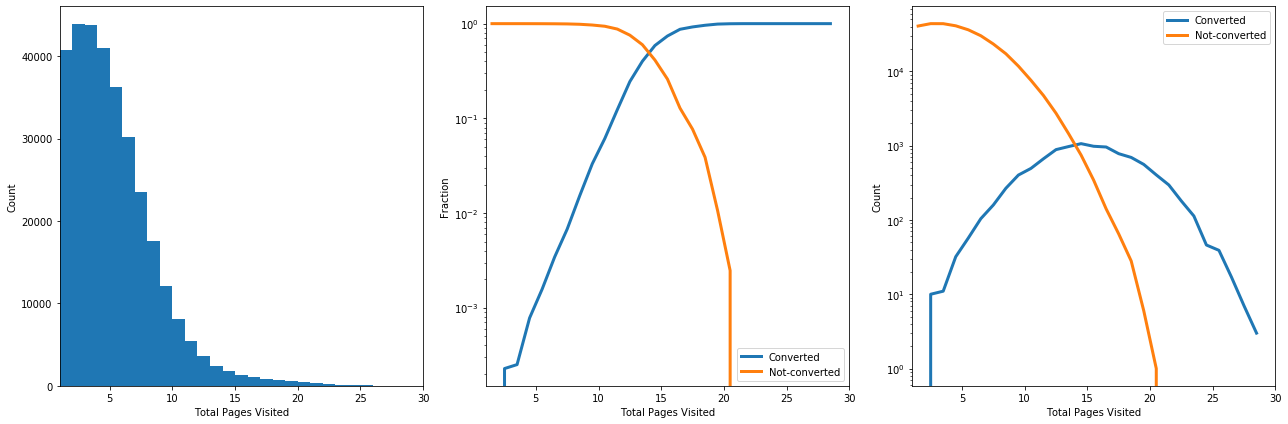

In [84]:
#
# Looking at age, but cutting off distribution around 99% 
# (rather than all the way up to 100).
#
bins = np.arange(1,30,1)
converted, bins = np.histogram(df['total_pages_visited'], weights=df['converted'],
                          bins = bins)
not_converted, bins = np.histogram(df['total_pages_visited'],
                                   weights=np.abs(df['converted']-1),
                                   bins = bins)
cent = 0.5*(bins[1:]+bins[:-1])
total = converted+not_converted

fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,6)

ax[0].hist(df['total_pages_visited'],bins=bins)
ax[0].set_ylabel('Count')

f_c = converted/total
f_c[total==0] = np.nan
f_nc = not_converted/total
f_nc[total==0] = np.nan

ax[1].plot(cent, f_c, lw = 3, color = 'C0', label = 'Converted')
ax[1].plot(cent, f_nc, lw=3,color = 'C1', label = 'Not-converted')
ax[1].semilogy()
ax[1].set_ylabel("Fraction")
ax[1].legend(loc='best')

ax[2].plot(cent, converted, lw = 3, color = 'C0', label = 'Converted')
ax[2].plot(cent, not_converted, lw=3,color = 'C1', label = 'Not-converted')
ax[2].semilogy()
ax[2].set_ylabel("Count")
ax[2].legend(loc='best')

for a in ax:
    a.set_xlabel('Total Pages Visited')
    a.set_xlim(1,30)

plt.tight_layout()

There is a wide range of pages viewed, but again looks somewhat gaussian (truncated) with a long tail to up to 29 pages! The majoriy are in the few to several range. However, looking at the right hand plot, it is clear that the conversion fraction does something intersting at around 12 pages viewed. Above this point a majority of users are converted, below this point they are not (by fraction).

Again, lets look at the raw numbers to double check what is happening here. Here we see somehing intersting, that the total number of converted users does not increase monotonically with toal pages viewed. This descreases again after about 16 pages, but the fraction remains high since nearly everyone beyond this point still converts (the non-conversion count drops much faster).

Text(0.5, 0, 'Total Pages Viewed')

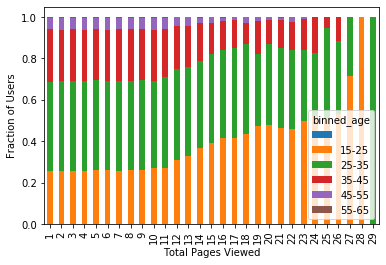

In [96]:
temp_age = np.array(['       ']*df['age'].count())
val = np.arange(15,66,10)
for i in np.arange(len(val)-1):
    temp_age[(df['age'] < val[i+1])*(df['age']>=val[i])] = "%02i-%02i"%(val[i],val[i+1])

df['binned_age'] = temp_age

(df.groupby(['total_pages_visited','binned_age']).size()/df.groupby(['total_pages_visited']).size()).unstack().plot(kind='bar',
                                                                       stacked=True)
plt.ylabel('Fraction of Users')
plt.xlabel('Total Pages Viewed')
#plt.semilogy()
#plt.ylim(0.95,1)

Out of curiosity, it does appear to be that there is also a correlation with total pages viewed and age. Younger viewers (those likely to convert) are also those that view more pages. It is likely then that the trend here in total pages viewed is driven by the fact that younger users are more likely to view more pages.

However, this is not as obvious as a trend for the oldest population (55-65) which does not seem to reach the same page-view levels as the younger population but still has that uptick in conversion as a function of age. This is maybe an additional interesting population to look at. 

## Source

Source represents where the users came from before the website. Lets look at the fraction of users converted in each category, keeping in mind that the mean for conversion for this dataset is that 3.22% of users convert. 

In [113]:
print(df.groupby(['source']).size())
print('------------  Fraction converted by source -----------------')
df.groupby(['source','converted']).size() / df.groupby(['source']).size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64
------------  Fraction converted by source -----------------


source  converted
Ads     0            0.965517
        1            0.034483
Direct  0            0.971831
        1            0.028169
Seo     0            0.967105
        1            0.032895
dtype: float64

It looks like there is a very slightly better change of conversion (3.4%) for users coming from Ads than Direct, while search engine results are in-line with the mean (this makes sense since it is a majority of the users).

In [181]:
print('------------  Fraction new users by source ------------------')
df.groupby(['source','new_user']).size() / df.groupby(['source']).size()

------------  Fraction new users by source ------------------


source  new_user
Ads     0           0.314300
        1           0.685700
Direct  0           0.313146
        1           0.686854
Seo     0           0.315319
        1           0.684681
dtype: float64

## Country

In [125]:
print(df.groupby(['country']).size() / df['country'].count())
print('------------  Fraction converted by country ------------------')
df.groupby(['country','converted']).size() / df.groupby(['country']).size()

country
China      0.242258
Germany    0.041290
UK         0.153226
US         0.563226
dtype: float64
------------  Fraction converted by country ------------------


country  converted
China    0            0.998668
         1            0.001332
Germany  0            0.937500
         1            0.062500
UK       0            0.947368
         1            0.052632
US       0            0.962199
         1            0.037801
dtype: float64

A majority of the users come from the US (a little over half), with China making up the second largest userbase. Unsurprisingly, since the US is the majority category here its conversion fraction is most similar to the mean of the dataset -- however, it is a bit higher than the mean. It is clear that China's very low (0.1%) conversion rate is what drops the mean, and this is an obvious userbase to target to drive up conversion rate. Interestingly, Germany and UK's conversion rates are quite high, indicating that whatever the company is doing works the best in those two areas.

In [165]:
print('------------  Fraction new users by country ------------------')
df.groupby(['country','new_user']).size() / df.groupby(['country']).size()

------------  Fraction new users by country ------------------


country  new_user
China    0           0.301480
         1           0.698520
Germany  0           0.322763
         1           0.677237
UK       0           0.320165
         1           0.679835
US       0           0.318015
         1           0.681985
dtype: float64

And looking at the above, the increase in conversion for Germany and UK is not because there happens to be more returning users there than the US.

# Model

Now we can construct a quick model to try and predict conversion rate. We have a few key things to keep in mind here:

1) The features are of mixed types: continuous (age), integers (total pages viewd), binary categorical (new user), and categorical (country, source). Something like a SVM would not work well here. 

2) The target class is unbalanced. Accuracy would be a bad performance metric here. In addition, we would likely rather adopt a metric geared towards limiting the number of false positives to be pessimistic. This ultimately depends somewhat on the business and goals, but it is likely better to have more false negatives in this case and be pleasantly surprised when a user converts that we predicted would not, than the opposite, particularly if this model is important in setting budget expectations. 

Due to the inbalanced classes, F1 scoring is a good obtion to evaluate the performance of the model.

In [154]:
# given the above, I've decided to try a gradient boosted decision tree
# which tends to give good results out-of-the-box
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

#
# First we need to split the data into training and test
#
df = pd.read_csv('./input/conversion_data.csv')


X_train, X_test, y_train, y_test = train_test_split(df.drop('converted',axis=1),
                                                    df['converted'],
                                                    random_state = 0)

In [155]:
#
# To handle the country and source categories, we need to do one-hot-coding
# of the country and source features.
#
# This is OK to do in this case since the number of features generated is 
# not too overbearing for memory as there are only 3 source categories
# and 4 country categories. 100's would potentially require additional 
# solutions and further feature engineering.
#
def one_hot_code_categories(data):
    
    data = pd.concat([data, pd.get_dummies(data['country'],prefix='country')],axis=1)
    data = pd.concat([data, pd.get_dummies(data['source'],prefix='source')],axis=1)

    
    # and strip originals
    data.drop('country',axis=1,inplace=True)
    data.drop('source',axis=1,inplace=True)
    
    return data

X_train = one_hot_code_categories(X_train)
X_test  = one_hot_code_categories(X_test)

In [162]:
#
# define a function to train and test a classifier and 
# return useful information on its performance. This
# will be used later.
#
def train_and_test_model(_X_train, _X_test, _y_train, _y_test, **kwargs):

    clf = GradientBoostingClassifier(random_state=0, **kwargs)
    clf.fit(X_train,y_train)
    train_f1    = f1_score(_y_train, clf.predict(_X_train))
    test_f1     = f1_score(_y_test, clf.predict(_X_test))
    train_acc   = clf.score(_X_train, _y_train)
    test_acc    = clf.score(_X_test, _y_test)
    
    print("Training Accuracy: %5.5f"%(train_acc))
    print("Test Accuracy: %5.5f"%(test_acc))    
    print("Training F1 score: %5.5f"%(train_f1))
    print("Test F1 score: %5.5f"%(test_f1))
    
    return clf, train_f1, test_f1

In [164]:
# define a dummy classifier to get a baseline idea of what
# we MUST be able to beat to say we accomplished anything
dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
dummy_train_acc = dummy_clf.score(X_train, y_train)
dummy_test_acc  = dummy_clf.score(X_test, y_test)
print("Dummy Classifier training accuracy: %5.5f"%(dummy_train_acc))
print("Dummy Classifier test accuracy: %5.5f"%(dummy_test_acc))
print("\n\n")


# define a default GB classifier to get a baseline idea of performance
default_clf, default_train_f1, default_test_f1 = train_and_test_model(X_train,X_test,y_train,y_test)

Dummy Classifier training accuracy: 0.96794
Dummy Classifier test accuracy: 0.96715



Training Accuracy: 0.98628
Test Accuracy: 0.98559
Training F1 score: 0.76137
Test F1 score: 0.75330


Default parameters do fairly well and do have an improvement on accuracy over the dummy classifier. The F1 score on the training data and the test data are similar and fairly high (0.76 and 0.75). This is likely a good choice model, but we may be able to do a little bit better with some parameter tuning:

In [179]:
#
#
# For time reasons, I am just going to do a simple and quick sequence
# of parameter tuning, iterating over a few of the most-likely to effect
# improvement 
#
num_values = len(df)


parameters = { 'learning_rate' : [0.01, 0.05, 0.1,0.2],
               'min_samples_split' : [2, 10, 100, 1000],
               'min_samples_leaf' : [1,10],
               'max_depth' : [3,5,8]}

grid_search = GridSearchCV( GradientBoostingClassifier(random_state=0),
                            param_grid = parameters,
                            scoring = 'f1',  # f1 scoring
                            cv     = 3,      # num of cross validations - 3 to make this quicker
                            n_jobs = -1      # use all cores available
                          )

grid_search.fit(X_train, y_train)
              

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...ge=None,
                                                  presort='a

In [183]:
#print(grid_search.cv_results_)
#print("------------------------")
print(grid_search.best_params_)
print("------------------------")
print(grid_search.best_score_)

{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 100}
------------------------
0.7637001312711852


In [182]:
# now lets train a model using the best parameters 
# 
# Best parameters : {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 100}
#


tuned_clf, tuned_train_f1, tuned_test_f1 = train_and_test_model(X_train,X_test,y_train,y_test,
                                                                **grid_search.best_params_)

Training Accuracy: 0.98654
Test Accuracy: 0.98567
Training F1 score: 0.77017
Test F1 score: 0.75878


It appears that doing this parameter tuning did indeed generate a set of parameters that improved the classifier, but only by a VERY VERY small amount. With more time / resources this can be done a bit better with a more iterative process tuning certain parameters while fixing others, but it is possible that this suggests a different model should be tested to see if the results could be improved first before dedicating more time into squeeze out a few more hundredths of a percent. 

However, this is sufficient for this exercise.

# Summary and Takeaways

Based on the exploratory analysis and model building, the following is a summary of key things learned about this dataset and possible avenues for improving conversion going forward:

- Younger users -- by fraction -- convert more than older users, though there is a population in the 55-65 year age range that seems to convert at a higher-than-expected rate (though not more than younger users).

- Returning users convert more than new users, though most of the traffic is from new users. The ratio of new to returning users does not seem to depend significantly on country of origin.

- A majority of the users come from the U.S., but China makes up the second largest user base and has the lowest (by far) conversion rate. Germany and the UK both have higher conversion rates than the US.

- Time spent on the website (by number of page views) is a strong predictor of conversion, with those viewing more than ~12 pages converting at a higher rate than not. 

- There is not a dramatic difference in conversion rate across sources, though direct link users convert at a lower rate (this is mostly because these are more returning users).

Given this above, this suggests the following may be good strategies and questions to ask for the company to pursue to improve conversion:

- **Improve Conversion Rate in China**: The abismal conversion rate in China is an obvious place to start. More should be done to better market product to Chinese costumers. This may pose significant logistical challenges -- however -- depending on the details of the company (e.g. shipping, customs, local legal restrictions). 


- **Increase Time Spent on the Website.** There could be multiple strategies to do this depending on the company, but placing more frequent and more enticing links to additional internal pages is one viable option. Even better if this is done by providing clear, attractive links to other pages of interest that are either directly related to the one currently viewed based on keywords, or based on previous users behaviors / interests. This is an obvious place where A/B testing could be done to demonstrate improvement between website design / features.


- **Decrease Churn**: New users make up the bulk web traffic but returning users are more likely to convert. While it may be the case that this website is seeing a sudden increase in growth of traffic and there just has not been enough time for the new users to return, this could also suggest that more should be done to decrease churn. It would be worthwhile to investigate (pontentially with a survey to returning users) why users come to the website in the first place and why users return to understand what can be done to convince more users to return.


- **Learn from Germany and the UK**: Conversion rate in Germany and the UK is higher than average. The company should examine why their performance here is better than in the US and China to try and better translate this success to existing (and new) markets.